# 9. Support vector machine

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

In [9]:
def find_range(Xx, Xy):
    xmin, xmax = Xx.min() - 0.1, Xx.max() + 0.1
    ymin, ymax = Xy.min() - 0.1, Xy.max() + 0.1
    if xmax - xmin < ymax - ymin:
        xmid = (xmax + xmin) / 2
        xmin = xmid - (ymax - ymin) / 2
        xmax = xmid + (ymax - ymin) / 2
    else:
        ymid = (ymax + ymin) / 2
        ymin = ymid - (xmax - xmin) / 2
        ymax = ymid + (xmax - xmin) / 2
    return ((xmin, xmax), (ymin, ymax))

def init_graph(X, Y, dpi=100, figsize=(6,6)):
    (xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == -1)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')

def draw_line(ax, wx, wy, b, ls, name='', color='tab:gray'):
    def f(x, wx, xy, b):
        return - wx / wy * x - b / wy
    
    x = np.array(ax.get_xlim())
    y = f(x, wx, wy, b)
    ax.plot(x, y, color=color, ls=ls, label=f'{name}')

def draw_margins(ax, wx, wy, Xx, Xy, svn, svp, s=None):
    length = np.sqrt(wx ** 2 + wy ** 2)
    margin = 1 / length

    for i in svn:
        x, y = Xx[i], Xy[i]
        ax.scatter([x], [y], s=s, facecolors='none', edgecolors='tab:blue')
        ax.plot([x, x + wx * margin / length], [y, y + wy * margin / length], ls=':', color='tab:blue')
        
    for i in svp:
        x, y = Xx[i], Xy[i]
        ax.scatter([x], [y], s=s, facecolors='none', edgecolors='tab:red')
        ax.plot([x, x - wx * margin / length], [y, y - wy * margin / length], ls=':', color='tab:red')

def plot_support_vectors(ax, X, Y, svs, s=None):
    for i in svs:
        color = 'tab:red' if Y[i] == 1 else 'tab:blue'
        ax.scatter([X[i][0]], [X[i][1]], s=s, facecolors='none', edgecolors=color)

def draw_heatmap(ax, fig, X, Y, model, step=1, N=1024):
    (xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T
    C = model.decision_function(XY).reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

## 9.1 Linear model

In [10]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)
Y = 2 * Y - 1

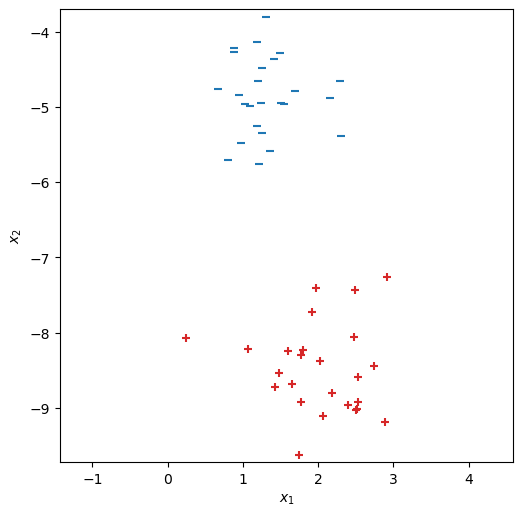

In [11]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
plt.show()

## 9.3 Training linear SVM

In [12]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X, Y)

SVC(kernel='linear')

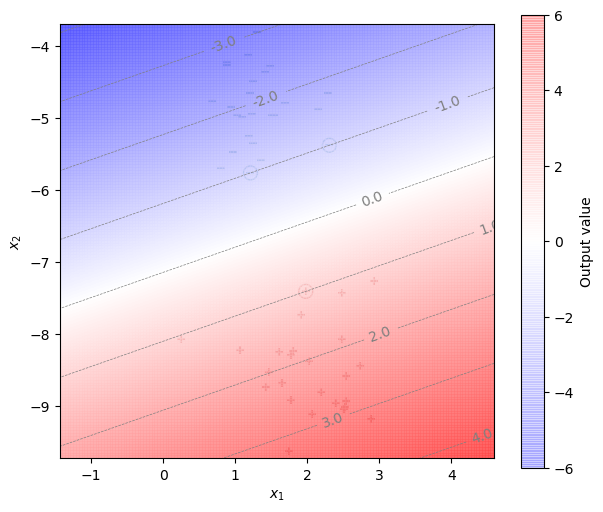

In [13]:
fig, ax = init_graph(X, Y, figsize=(7, 6))
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, model.support_, s=100)
draw_heatmap(ax, fig, X, Y, model)
plt.show()

In [15]:
w = model.dual_coef_[0] @ X[model.support_]

print(f'coefficient: {model.coef_[0]}')
print(f'intercept: {model.intercept_[0]}')
print(f'indices of support vectors: {model.support_}')
print(f'labels of support vectors: {Y[model.support_]}')
print(f'y_i * alpha_i of support vectors: {model.dual_coef_[0]}')
print(f'sum of y_i * alpha_i: {np.sum(model.dual_coef_[0])}')
print(f'w* = sum of y_i * alpha_i * x_i: {w}')
print(f'b* = y_s - w* @ x_s: {Y[model.support_[0]] - np.dot(w, X[model.support_[0]])}')

coefficient: [ 0.36586586 -1.04568619]
intercept: -7.470506295184168
indices of support vectors: [ 4 30 40]
labels of support vectors: [-1 -1  1]
y_i * alpha_i of support vectors: [-0.51806476 -0.0957497   0.61381447]
sum of y_i * alpha_i: 2.220446049250313e-16
w* = sum of y_i * alpha_i * x_i: [ 0.36586586 -1.04568619]
b* = y_s - w* @ x_s: -7.470906877495697


## 9.5 Training kernel SVM

In [16]:
from sklearn.datasets import make_circles
X, Y = make_circles(100, factor=.1, noise=.1) # impossible to classify by linear SVM
Y = Y * 2 - 1

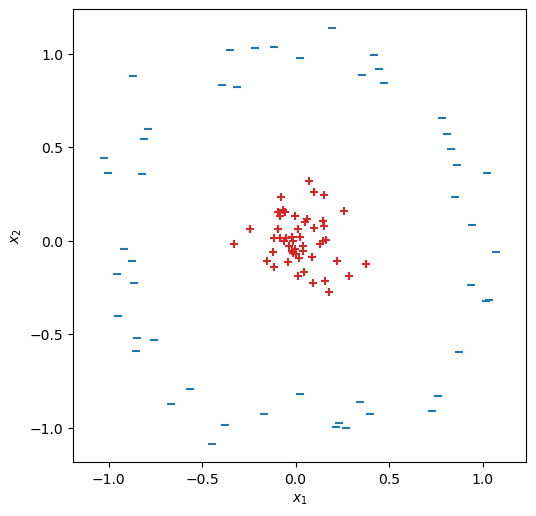

In [17]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
plt.show()

In [19]:
model = SVC(kernel='poly', degree=2, C=1e6)
model.fit(X, Y)

SVC(C=1000000.0, degree=2, kernel='poly')

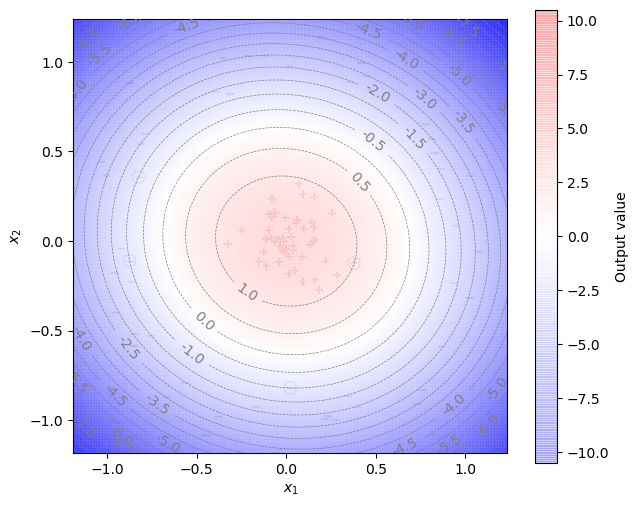

In [20]:
fig, ax = init_graph(X, Y, figsize=(7, 6))
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, model.support_, s=80)
draw_heatmap(ax, fig, X, Y, model, step=0.5)
plt.show()

In [21]:
model = SVC(kernel='rbf', degree=2, C=1e6)
model.fit(X, Y)

SVC(C=1000000.0, degree=2)

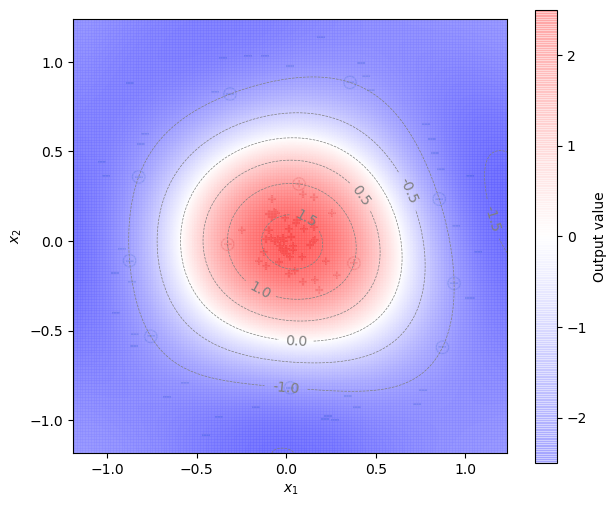

In [22]:
fig, ax = init_graph(X, Y, figsize=(7, 6))
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, model.support_, s=80)
draw_heatmap(ax, fig, X, Y, model, step=0.5)
plt.show()